In [1]:
import pandas as pd

In [2]:
df_capital = pd.read_csv('datasets/lacapital.csv')

df_capital.dropna(inplace=True)

df_norm = df_capital.copy()

# Limpieza y normalización de texto 

In [3]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words_extra = ['año', 'años', 'dos', 'tres', 'si', 'sí']

for word in stop_words_extra:
    stop_words.add(word)

def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', input_str)
  return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
  return " ".join(filtered_text)

for col in df_capital.columns[:-2]:
    df_norm[col] = df_norm[col].str.lower()
    df_norm[col] = df_norm[col].str.replace('[^\w\s]', '', regex=True)
    df_norm[col] = df_norm[col].apply(remove_stopwords)
    df_norm[col] = df_norm[col].apply(remove_accents)

[nltk_data] Downloading package stopwords to /home/isaias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/isaias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Ejercicio 2

In [4]:
df_capital['categoria'].value_counts()

categoria
Ovación                  57
Política                 48
La Ciudad                32
Zoom                     31
Policiales               22
Información General      17
Economía                 16
La Región                16
Mundial de Rugby 2023     8
El Mundo                  6
Educación                 4
Turismo                   4
Negocios                  2
La región                 2
Cristina                  1
Opinión                   1
Julián Montoya            1
Baby Etchecopar           1
Colón                     1
Pepín rodríguez simón     1
Name: count, dtype: int64

In [5]:
categorias = df_norm['categoria'].value_counts()
categorias = categorias[categorias >= 10].index[:5]

In [6]:
categorias_df = list()

for categoria in categorias:
    temp_df = df_norm[df_norm['categoria'] == categoria]
    categorias_df.append(temp_df.sample(22, random_state=1))

In [7]:
x = list()
y = list()

for df in categorias_df:
    x += df['titulo'].tolist()
    y += df['categoria'].tolist()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [9]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=1)

In [10]:
vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

modelo_LR = LogisticRegression(max_iter=1000)
modelo_LR.fit(x_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [11]:
y_pred_LR = modelo_LR.predict(x_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

In [12]:
print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

Precisión Regresión Logística: 0.5454545454545454
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

      ciudad       1.00      0.40      0.57         5
     ovacion       0.18      1.00      0.31         2
  policiales       1.00      0.44      0.62         9
    politica       0.67      0.67      0.67         3
        zoom       1.00      0.67      0.80         3

    accuracy                           0.55        22
   macro avg       0.77      0.64      0.59        22
weighted avg       0.88      0.55      0.61        22



# Ejercicio 3

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

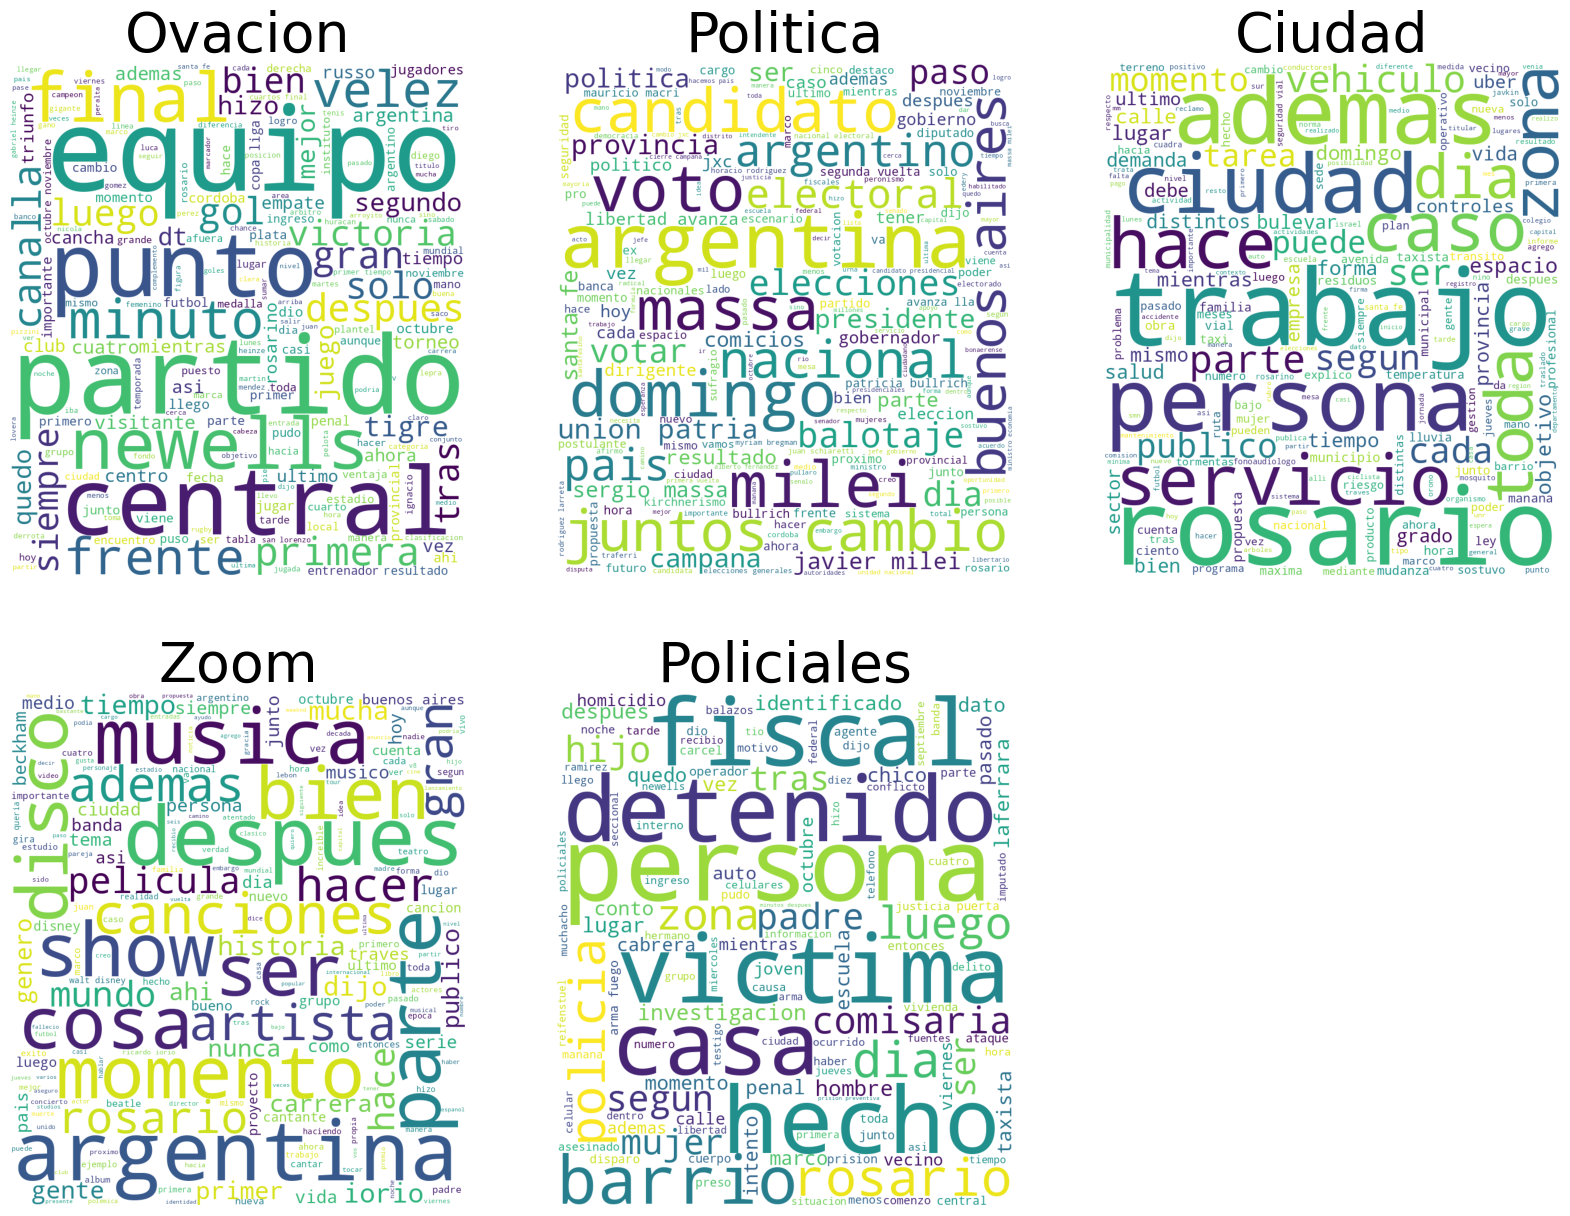

In [14]:
fig = plt.figure(figsize=(20, 15))

for idx, categoria in enumerate(categorias):
    texto = ' '.join(df_norm[df_norm['categoria'] == categoria]['texto'])

    wordcloud = WordCloud(width=800, height=900,
                            background_color='white',
                            stopwords=None,
                            min_font_size=10).generate(texto)


    ax = fig.add_subplot(2, 3, idx + 1)
    ax.imshow(wordcloud)
    plt.title(f'{categoria.capitalize()}', fontsize=40)
    plt.axis("off")


# Ejercicio 4

In [17]:
import torch
from transformers import BertTokenizer, BertModel
from torch.nn.functional import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model     = BertModel.from_pretrained('bert-base-multilingual-cased')

In [18]:
ovacion_norm = df_norm[df_norm['categoria'] == 'ovacion'][:22]
ovacion      = df_capital[df_capital['categoria'] == 'Ovación'][:22]

In [31]:
ovacion['titulo']

1     Provincial debuta este sábado en la Liga Argen...
4     Plaza juega por la salvación en el Top 12 de l...
5     Newell's: las variantes lo enderezaron y venci...
6     Newell's y un triunfo que lo catapulta a las c...
7     Copa Santa Fe: Central al final debió ganarlo ...
17    Heinze: "Es muy lindo volver a casa con un res...
18    Rosario, sede del primer encuentro femenino de...
20    Asociación Rosarina de Fútbol: tiempo de defin...
23    Verstappen tenía la pole con el auto decorado ...
24    Méndez fue el destacado en el triunfo de Newell's
25    Quién es el rosarino que le decoró el auto al ...
31    Central busca el mejor envión final para copar...
35     Newell's consiguió otro triunfazo en rodeo ajeno
43    Newell's le ganó a Tigre en el final con goles...
60    Qué pasa si Los Pumas empatan con los All Blac...
62    Mal momento para un campeón: Papu Gómez será s...
63    Las cábalas no se alteran: Central cambió la c...
69    Escaleras al cielo: se cumple un aniversar

In [19]:
def crear_embeddings(df, col, n=None):
    
    embeddings_list = list()

    if n == None:
        n = len(df)

    for title in df[col][:n]:
        tokens = tokenizer.tokenize(title)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        token_ids = torch.tensor([token_ids])

        with torch.no_grad():
            outputs = model(token_ids)
            embeddings = outputs.last_hidden_state

        embeddings_list.append(embeddings[0])
        
    return embeddings_list

In [20]:
a = crear_embeddings(ovacion_norm, 'titulo')
b = crear_embeddings(ovacion, 'titulo')

In [33]:
ovacion['titulo']

1     Provincial debuta este sábado en la Liga Argen...
4     Plaza juega por la salvación en el Top 12 de l...
5     Newell's: las variantes lo enderezaron y venci...
6     Newell's y un triunfo que lo catapulta a las c...
7     Copa Santa Fe: Central al final debió ganarlo ...
17    Heinze: "Es muy lindo volver a casa con un res...
18    Rosario, sede del primer encuentro femenino de...
20    Asociación Rosarina de Fútbol: tiempo de defin...
23    Verstappen tenía la pole con el auto decorado ...
24    Méndez fue el destacado en el triunfo de Newell's
25    Quién es el rosarino que le decoró el auto al ...
31    Central busca el mejor envión final para copar...
35     Newell's consiguió otro triunfazo en rodeo ajeno
43    Newell's le ganó a Tigre en el final con goles...
60    Qué pasa si Los Pumas empatan con los All Blac...
62    Mal momento para un campeón: Papu Gómez será s...
63    Las cábalas no se alteran: Central cambió la c...
69    Escaleras al cielo: se cumple un aniversar

In [39]:
similarity = cosine_similarity(a[0].mean(dim=0).unsqueeze(0), a[3].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y segunda oración: {similarity.item()}")

similarity = cosine_similarity(a[0].mean(dim=0).unsqueeze(0), a[2].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y tercera oración: {similarity.item()}")

Similitud entre la primera y segunda oración: 0.6489676833152771
Similitud entre la primera y tercera oración: 0.6436692476272583


In [22]:
titulos_ovacion = []

for ii in ovacion_norm.titulo:
  titulos_ovacion.append(ii)

embeddings_list = []

for sentence in titulos_ovacion:
    tokens = tokenizer.tokenize(sentence)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    token_ids = torch.tensor([token_ids])

    with torch.no_grad():
        outputs = model(token_ids)
        embeddings = outputs.last_hidden_state

    embeddings_list.append(embeddings[0])


similarity = cosine_similarity(embeddings_list[0].mean(dim=0).unsqueeze(0), embeddings_list[6].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y segunda oración: {similarity.item()}")

similarity = cosine_similarity(embeddings_list[0].mean(dim=0).unsqueeze(0), embeddings_list[21].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y tercera oración: {similarity.item()}")

Similitud entre la primera y segunda oración: 0.6539000272750854
Similitud entre la primera y tercera oración: 0.6109477281570435


# Ejercicio 5

In [50]:
noticia = ovacion['texto'][18]

In [61]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Cargar el modelo de spaCy
# !python -m spacy download es_core_news_md
nlp = spacy.load('es_core_news_md')

In [62]:
doc = nlp(noticia)

# Función para generar un resumen extractivo usando PageRank
def summarize(text, num_sentences=5):
    
    lemmatized_sentences = list()
    original_sentences   = list()
    doc = nlp(text)
    
    for sent in doc.sents:
        lemmatized_sentence = ' '.join(
                                        token.lemma_ for token in sent
                                        if not token.is_stop and 
                                        not token.is_punct)

        if lemmatized_sentence.strip() != '':
            lemmatized_sentences.append(lemmatized_sentence)
            original_sentences.append(str(sent).strip())

    # Procesar las oraciones lematizadas con spaCy para obtener sus vectores
    lemmatized_docs = [nlp(sent) for sent in lemmatized_sentences]

    # Obtenemos una lista con los vectores de cada oración
    sentence_vectors = [sent.vector for sent in lemmatized_docs]

    # Devuelve una matriz de similitud entre las oraciones filtradas
    similarity_matrix = cosine_similarity(sentence_vectors)
    
    # Crear un grafo a partir de la matriz de similitud
    nx_graph = nx.from_numpy_array(similarity_matrix)
    
    # Aplicar PageRank al grafo
    scores = nx.pagerank(nx_graph)
    
    # Ordenar las oraciones por su puntuación y seleccionar las mejores
    ranked_sentences = sorted(
                            (
                                (scores[i], s) for i, s
                                in enumerate(original_sentences)
                            ),
                            reverse=True)
    
    return ' '.join(ranked_sentences[i][1] for i in range(num_sentences))

In [71]:
resumen = summarize(noticia, num_sentences=2)

In [72]:
resumen

'Rosario fue elegida para realizar el primer encuentro provincial de ligas sub-12 en el fútbol femenino, que se realizará este sábado a partir de las 10 y se llevará a cabo en el predio de la Asociación Rosarina de Fútbol, exBatallón 121, ubicado en Ayacucho al 5000, muy cerca del Museo del Deporte. La modalidad de la misma será de la siguiente manera: cada equipo contará con un plantel de 18 jugadoras de las categorías 2012.'

In [73]:
noticia

'Rosario fue elegida para realizar el primer encuentro provincial de ligas sub-12 en el fútbol femenino, que se realizará este sábado a partir de las 10 y se llevará a cabo en el predio de la Asociación Rosarina de Fútbol, exBatallón 121, ubicado en Ayacucho al 5000, muy cerca del Museo del Deporte. El encuentro contará con 7 asociaciones oficiales: Santafesina, Rosarina A y B, Casildense, Rafaelina, Esperancina, Sanlorencina y San Martín. Los partidos serán para compartir, disfrutar y con el objetivo de que sea una jornada recreativa histórica. La entrada será gratuita.\nLa modalidad de la misma será de la siguiente manera: cada equipo contará con un plantel de 18 jugadoras de las categorías 2012. Vale aclarar que serán 9 titulares y luego se podrán realizar variantes.\nLa duración de los partidos será de 30 minutos y los cambios se realizarán a los 15 minutos. Se permitirá la sustitución de las 9 jugadoras que iniciaron el juego. Por último cabe mencionar que los compromisos se jugar